# Titanic Spacechip - Kaggle Competition

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

## Task

In this competition your task is to **predict whether a passenger was transported to an alternate dimension** during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.


# Dataset

## train.csv
Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

- `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.

- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

- `Destination` - The planet the passenger will be debarking to.

- `Age` - The age of the passenger.

- `VIP` - Whether the passenger has paid for special VIP service during the voyage.

- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

- `Name` - The first and last names of the passenger.

- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### test.csv
Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

## sample_submission.csv
A submission file in the correct format.
`PassengerId` - Id for each passenger in the test set.



# Initial data exploration

In [7]:
from main import load_train_data, load_test_data

# Load data
titanic_train = load_train_data()
titanic_test = load_test_data()

# Explore the dataset
titanic_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


There are some missing values. Imputation will be necessary later on.

In [8]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [60]:
titanic = titanic_train.copy()

First, we note that there are some values which are objects and bools.

## HomePlanet & Destination

These two features can be one-hot encoded. For HomePlanet we only have three values.

## CryoSleep

Is a boolean value indicating whether the pax was on CryoSleep

## Cabin

Cabin is composed of three datum: Deck/Cabin Number/Side. This feature can be split into three, while Deck and Side can also be one-hot encoded.

## VIP

Boolean feature,

## RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

Indicate the expenses of each passenger. Maybe a feature with the total expenses could be meaningful, but maybe not. Maybe individual expense categories correlate better to the Transported label.

## Name

Maybe uninteresting? won't be used initially

## Transported

Label, indicating whether the pax was transported to another dimension or not.

## HomePlanet & Destination

In [61]:
titanic["HomePlanet"].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [62]:
titanic["Destination"].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [ ]:
# First, impute the features
cat_imputer = SimpleImputer(strategy="most_frequent")
cat_imputer.fit(titanic["HomePlanet"])

# One-hot encode the HomePlanet and Destination features.

<Axes: >

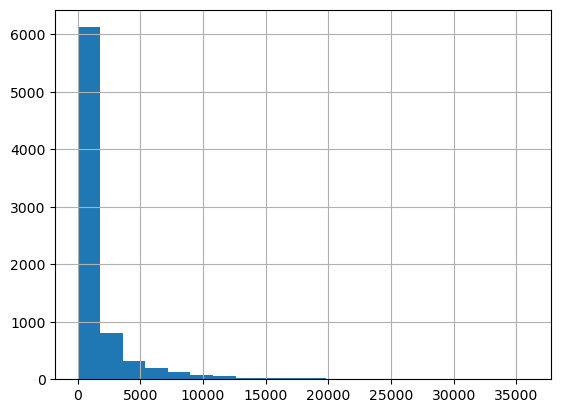

In [27]:


# Create a scatter matrix from a few of the potentially relevant numeric features.
# Make the Transformed column a numeric one
titanic_train["Transported"] = titanic_train["Transported"].astype(int)

# Create a feature for the total expenses
titanic_train["TotalExpenses"] = titanic_train["RoomService"] + titanic_train["FoodCourt"] + titanic_train[
    "ShoppingMall"] + titanic_train["Spa"] + titanic_train["VRDeck"]
titanic_train["TotalExpenses"].hist(bins=20)

<Axes: >

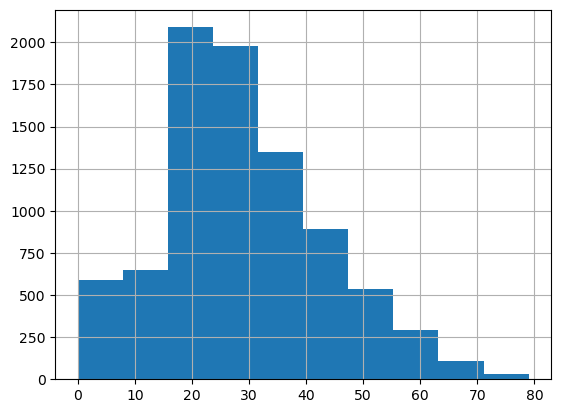

In [34]:
titanic_train["Age"].hist(bins=10)

(array([3.618e+03, 1.920e+02, 5.500e+01, 2.100e+01, 1.400e+01, 6.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00]),
 array([    0. ,  3598.7,  7197.4, 10796.1, 14394.8, 17993.5, 21592.2,
        25190.9, 28789.6, 32388.3, 35987. ]),
 <BarContainer object of 10 artists>)

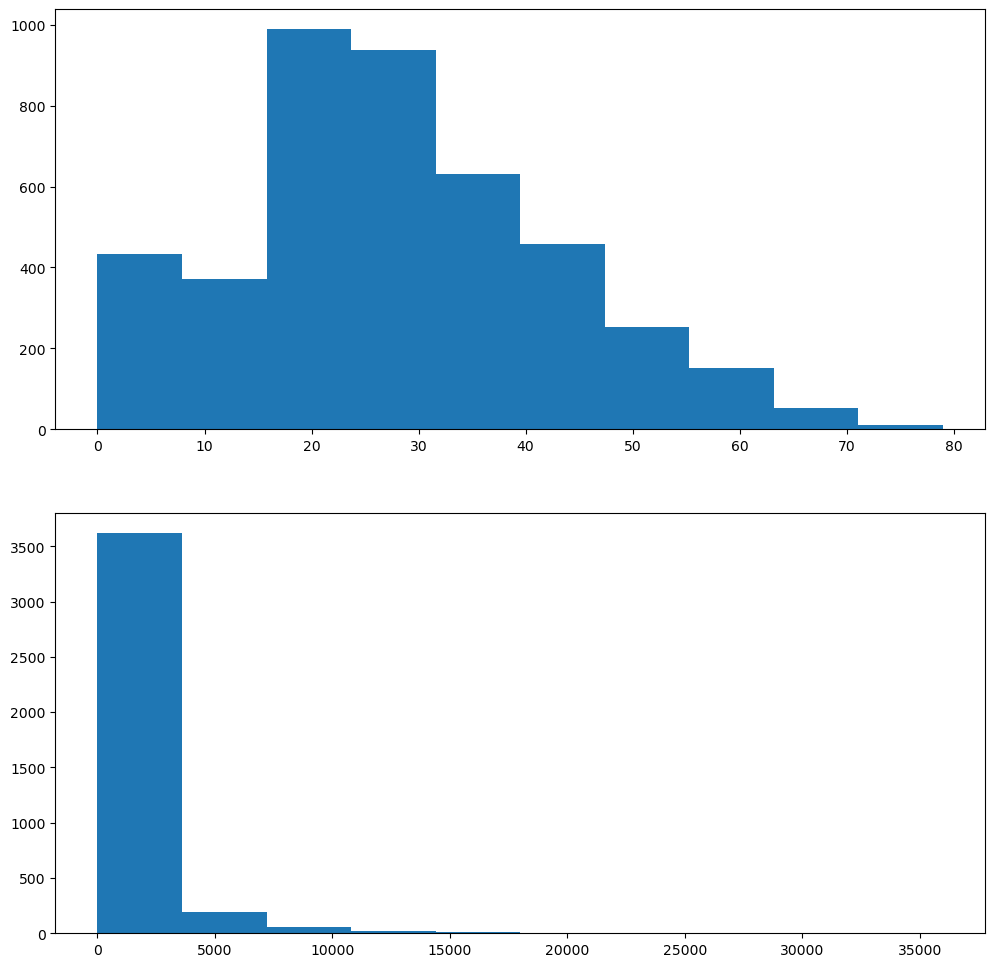

In [49]:

import matplotlib.pyplot as plt

# Plot histogram of number of Transported people according to their Age
plt, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].hist(titanic_train["Age"], weights=titanic_train["Transported"])
ax[1].hist(titanic_train["TotalExpenses"], weights=titanic_train["Transported"])

Apparently, there seems to be no strong correlation between transported passengers and their age or expenses. The transported passengers seem to have been representative of the whole population in this regard.

Inspect other features, such as CryoSleep, VIP, Deck and Side

In [59]:
# Transform the boolean columns to numbers
boolean_columns = ["Transported", "VIP", "CryoSleep"]

titanic_train[boolean_columns] = titanic_train[boolean_columns].astype(int)

ValueError: cannot convert float NaN to integer

In [58]:

# What proportion of the pax were in CryoSleep AND Transported?
cryo_sleep_and_transported = titanic_train["CryoSleep"] & titanic_train["Transported"]
corr_matrix = titanic_train.corr(numeric_only=True)
corr_matrix["Transported"].sort_values(ascending=False)

Transported      1.000000
FoodCourt        0.046566
ShoppingMall     0.010141
Age             -0.075026
TotalExpenses   -0.197671
VRDeck          -0.207075
Spa             -0.221131
RoomService     -0.244611
Name: Transported, dtype: float64

## Inspect non-numeric features

In [9]:
# First one is PassengerId, which should be actually treated as the index, since it identifies each passenger
titanic_train.set_index('PassengerId', inplace=True)
titanic_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [10]:
# Inspect home planet.
titanic_train["HomePlanet"].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [ ]:
# There are only three planets, we can one-hot encode those.